<p align="center">
  <img src="https://github.com/deel-ai/xplique/blob/master/docs/assets/banner.png?raw=true"/>
</p>

---

📘 <a href="https://deel-ai.github.io/xplique/api/attributions/integrated_gradients/"> IntegratedGradient Documentation</a>  |  <img src="https://github.githubassets.com/images/icons/emoji/octocat.png" width=20> <a href="https://github.com/deel-ai/xplique/blob/master/xplique/attributions/integrated_gradients.py"> Source</a>  | 📰 <a href="https://arxiv.org/abs/1703.01365"> Original Paper</a>

🦊 <a href="https://github.com/deel-ai/xplique/blob/master/TUTORIALS.md"> More Xplique tutorials</a>

---

_Author: Antonin Poché_

---

# Welcome to the **IntegratedGradients attribution** tutorial

In this tutorial, we will present the method and few tips to use the right parameters. We also answer to frequently asked questions and dig into the details of the parameters through examples.

💡 The IntegratedGradient attribution method was integrated into the Xplique framework and we propose here to have an overview of the possibilities you have to play with this method to explain the outputs of your model.

---

# **Table of content:**

- [The method](#intro)

- [IntegratedGradients parameters overview](#overview)

- [Parameters tuning tips](#tips)

- [Frequently asked questions](#faq)

- [Utilization and parameters impact examples](#examples)

    - [Set-up](#setup)

    - [IntegratedGradients simple utilization](simple)

    - [Parameters influence](#influence)

# <a name="intro"> The method

### **Attribution methods**

The main objective in attributions techniques is to highlight the discriminating variables for decision-making. For instance, with Computer Vision (CV) tasks, the main goal is to underline the pixels contributing the most in the input image(s) leading to the model’s output(s).



### **Back-propagation attribution methods**

Back-propagation methods are one of the two groups of attribution methods with perturbation based methods. Those methods use the weights of the model to back-propagate the importance from the prediction (class activation or regression) to the inputs. It was first introduced in 2013, with the saliency method from <a href="https://arxiv.org/abs/1312.6034">Simonyan et al</a>. Back-propagation methods can be seen as white-box methods as they need the weights of the model.

### **The IntegratedGradients method**

Integrated Gradients is a visualization technique resulting of a theoretical search for an explanatory method that satisfies two axioms, Sensitivity and Implementation Invariance (Sundararajan et al.).

<a href="https://arxiv.org/abs/1703.01365"> Sundararajan et al. 2017</a>: "*We consider the straightline path (in $R^n$) from the baseline $\bar{x}$ to the input $x$, and compute the gradients at all points along the path. Integrated gradients are obtained by cumulating these gradients.*"

Rather than calculating only the gradient relative to the image, the method consists of averaging the gradient values along the path from a baseline state to the current input sample $x$. The baseline state is often set to zero, representing the complete absence of features.

More precisely, with $\bar{x}$ the baseline state, $x$ the image, $c$ the class of interest and $S_c$ the unormalized class score (layer before softmax). The Integrated Gradient is defined as

$$IG(x) = (x - \bar{x}) \cdot \int_0^1{ \frac { \partial{S_c(\bar{x} + \alpha(x - \bar{x}))} } { \partial{x} } d\alpha }$$

In order to approximate from a finite number of steps, the implementation here use the Trapezoidal rule (<a href="https://en.wikipedia.org/wiki/Trapezoidal_rule">wikipedia</a>)  and not a left-Riemann summation, which allows for more accurate results and improved performance. (see <a href="https://arxiv.org/abs/1908.06214">Sotoudeh et Thakur - 2019</a> for a comparison of the methods).

# <a name="overview">IntegratedGradients attributes overview </a>

As most methods of the Xplique library, an explanation method have a few number of attributes (and their default values) useful to increase your explanation quality.

```python
explainer = IntegratedGradients(model,
                                output_layer: int = -1,
                                batch_size: int = 32,
                                steps: int = 50,
                                baseline_value: float = .0)
```

- The `output_layer` parameter is the index of the output layer corresponding to the label layer. The last layer layers can be activated (linear, softmax ...).

- The `batch_size` define the number of inputs to treat simultaneously. (Positive integer).

- The `steps` parameter is the number of points to interpolate between the baseline and the desired point. The value of `steps` has an linear impact on the simulation time. (Positive integer).

- The `baseline_value` parameter is a scalar used to create the baseline point.

The choices of `steps` and `baseline_value` are related to each other.

The detail on each attribute influence will be provided in the [Parameters influence](#influence) section.

# <a name="tips">Parameters tuning tips</a>

- The `output_layer` represent the index of the layer from which begin the back-propagation. It should be left to -1, i.e the last layer of the model or the class activation layer.
- The `batch_size` represent the number of perturbed images treated simultaneously. It has an impact on the memory usage. You may use the batch size from your model training.
- The `steps` parameter is the number of points to interpolate between the baseline and the desired point. The right setting is the smallest value after which the explanation are stable. This means that more points will not make the explanation more precise. `steps` default value is 50.

- The `baseline_value` parameter is a scalar used to create the baseline point. It should represent non-information. 0 or the mean of your values are often good values.

# <a name="faq">Frequently asked questions</a>

### **Out of memory error**

You asked too much memory from your RAM. This is usually cause by treating too much samples simultaneously, thus reducing the `batch_size` should resolve your problem. Otherwise you may check if there is nothing else runing on your machine.

### **The execution time is too long**

For each sample you query an explanation on, the gradient is computed on each interpolated points. Therefore it is naturally long, however if you want to reduce this time, you have two possibilities:
- You can reduce the number of `steps` as the computation is linearly dependent of this parameter.
- Finally you can choice to reduce the number of samples (images, timeseries) you want an explanation on. (Maybe wrongly classified samples are more interesting to analyze or if you evaluate your method through metrics, only a part of the test set could be sufficient).

### **The explanation does not make sense**

There could be five main causes to this:
- The `steps` parameter may not be big enough, you should increase it till the explanation do not change anymore.
- The `baseline_value` is outside of the expected range of values, you may try 0 or the mean of your values.
- The `targets` parameter of the `explain` method may have not adapted values. It should take values in $\{-1, 0, 1\}$, we often use the model prediction (one hot encoding after argmax) or the dataset labels. For regression, it should be only ones. Verify that your `targets` parameter values are in $\{-1, 0, 1\}$.
- If the model do not work well, it is natural that explaining its behavior will not be understandable. You can come to this conclusion if other explainability methods do not work well either. In this case, you may want to modify your model.
- The IntegratedGradient method may not be adapted to the model or the dataset. You will see it quickly if other explanability methods work well. In this case, you should just use the other methods.

# <a name="examples">Parameters details and examples</a>

This section will present the different parameters and their influence in details. It will be done through examples, therefore, a little set up part to load a model and an image is necessary. Then a simple utilization is provided, before an overview of the different parameters and their detail.

## <a name="sec">Set-up</a>

We start by importing Xplique and some other necessary libraries.

In [1]:
import numpy as np
from matplotlib import pyplot as plt
import tensorflow as tf
from math import ceil
from time import time

import xplique
from xplique.attributions import IntegratedGradients
from xplique.plots import plot_attributions
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, Flatten, Dense, BatchNormalization

Now we will load an image and a well-known model [Inception V3](https://keras.io/api/applications/inceptionv3/).

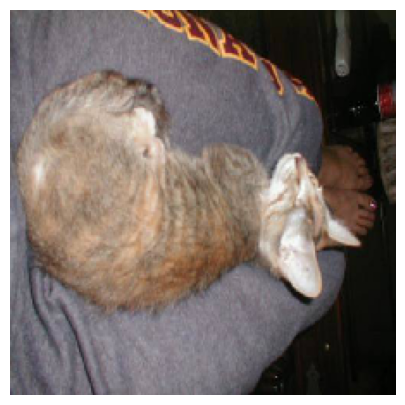

In [24]:
# load, prepare and show the sample
image = "cat.jpg"

x = np.expand_dims(tf.keras.preprocessing.image.load_img(image, target_size=(224, 224)), 0)
x = np.array(x, dtype=np.float32) / 255.0

y = np.expand_dims(tf.keras.utils.to_categorical(1, 2), 0)

plt.rcParams["figure.figsize"] = [12.5, 5]
plt.imshow(x[0])
plt.axis('off')
plt.show()

In [25]:
y.shape


(1, 2)

In [26]:
y

array([[0., 1.]], dtype=float32)

In [15]:
# Define the model
model = Sequential()

# Add a Conv2D layer for feature extraction
model.add(Conv2D(32, (3, 3), input_shape=(224, 224, 3), activation='relu'))

# Add a Flatten layer to prepare the data for classification
model.add(Flatten())

# Add a Dense layer without an activation function
model.add(Dense(64))

# Add a Dense layer with a softmax activation function for the final output
model.add(Dense(2, activation='softmax'))
model.load_weights("cats_vs_dogs.h5")

## <a name="simple">IntegratedGradients simple utilization</a>

This a minimal example on how to apply the IntegratedGradients method. This focus on the right specification of the IntegratedGradients method parameters. For further details and explanations on the attribution explainers API, please refer to the [Feature attribution tutorial](https://colab.research.google.com/drive/1XproaVxXjO9nrBSyyy7BuKJ1vy21iHs2)

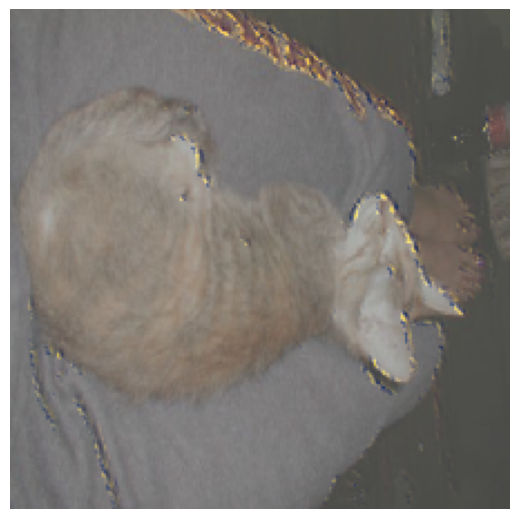

In [16]:
# instanciate explainer with arbitrary parameters
explainer = IntegratedGradients(model,
                                output_layer=-2,
                                steps=50, baseline_value=0)

# compute explanation by calling the explainer
explanation = explainer.explain(x, y)

# visualize explanation with plot_explanation() function
plot_attributions(explanation, x, img_size=5, cmap='cividis', cols=1, alpha=0.6)

The IntegratedGradients method needs a little bit of knowledge to use it to its full potential by choosing the adaptative parameters (see the [paper](https://arxiv.org/abs/1311.2901)). Therefore we propose to summarize those informations in [the parameters tuning tips part](#tips). The parameters are described and explained in the following sections.

## <a name="influence">IntegratedGradients parameters influence</a>

This section will present the influence of each parameter, it will be accompanied by visualization to illustrate it. Each parameter will be described one by one.

### **output_layer**

The `output_layer` parameter is an integer indexing the layer from which begin the back-propagations. The different papers consider the last layer of the neural neural which is the class activation layer. (The methods can also be applied to regression methods, please see the corresponding tutorial from the <a href="https://deel-ai.github.io/xplique/tutorials/"> list of Xplique tutorials</a>).

To come back to the `output_layer` parameter, we suggest not to change it as the resulting attributions would not be easily interpretable and may be misleading.

### **batch_size**

The `batch_size` parameter should be a positive integer, it indicates the number of perturbed images treated simultaneously.
- Too small values will increase the execution time.
- Too huge values may lead to out of memory errors.
This parameter should be set taking into account your hardware and the image size. The most simple solution is to used the same batch size you use during the training of your model.

### **baseline_value**

The `baseline_value` parameter refers to the baseline state defined in [the method definition](#intro). The given value is used to create the whole baseline image. It should represent non-information, as such, 0 is often used. The value should be in the range of features possible values, (between 0 and 1 for pixels for example).

However, many values could make sense, the mean or median of your features, the minimum or maximum of your features or even the middle between minimum and maximum.

baseline_value: 0


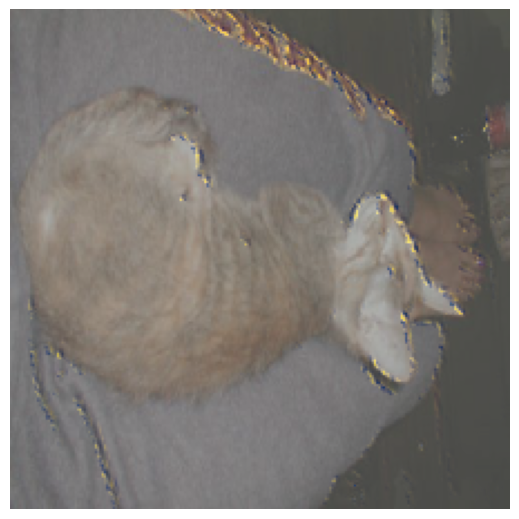

baseline_value: 0.5


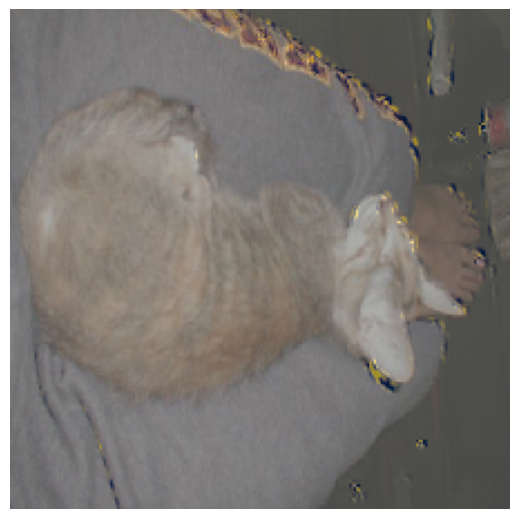

baseline_value: 1


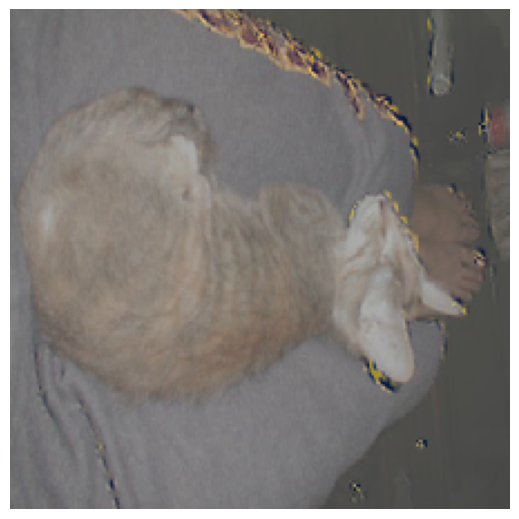

In [18]:
output_layer = -1
batch_size = 16
steps = 50
baseline_values = [0, 0.5, 1]

for baseline_value in baseline_values:
    explainer = IntegratedGradients(model,
                                    output_layer=output_layer, batch_size=batch_size,
                                    steps=steps, baseline_value=baseline_value)

    explanation = explainer.explain(x, y)

    print("baseline_value:", baseline_value)
    plot_attributions(explanation, x, img_size=5, cmap='cividis', alpha=0.6)
    plt.show()

### **steps**

The `steps` parameter is the number of elements used to compute the integration though the trapezoide rule as defined in [the method definition](#intro).

- A too small value of `steps` will not make a good estimator of the integral.
- While a too huge value will take much more time to compute.

The `steps` parameter should increased till convergence of the method.

steps: 2 -> 0.22s


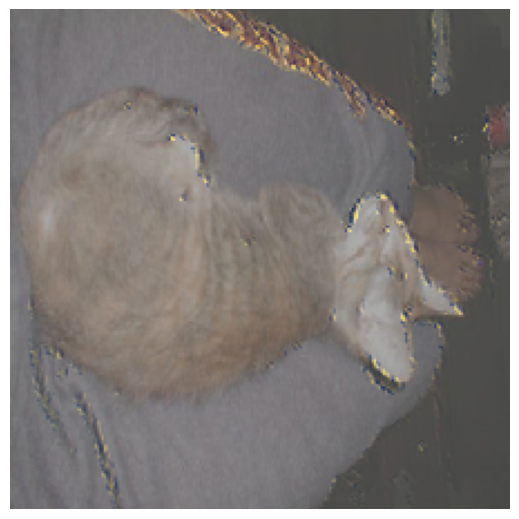

steps: 5 -> 0.76s


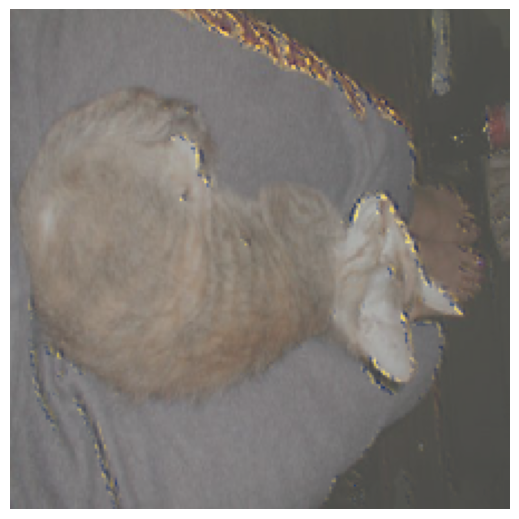

steps: 20 -> 0.29s


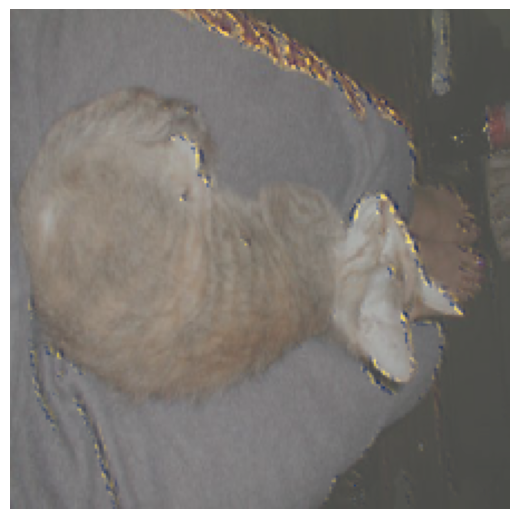

steps: 50 -> 0.1s


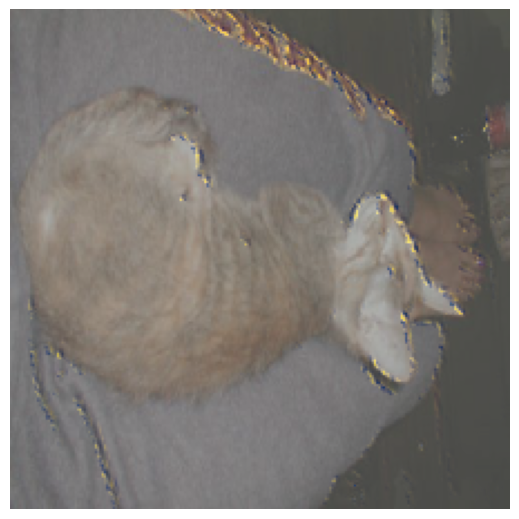

steps: 200 -> 0.51s


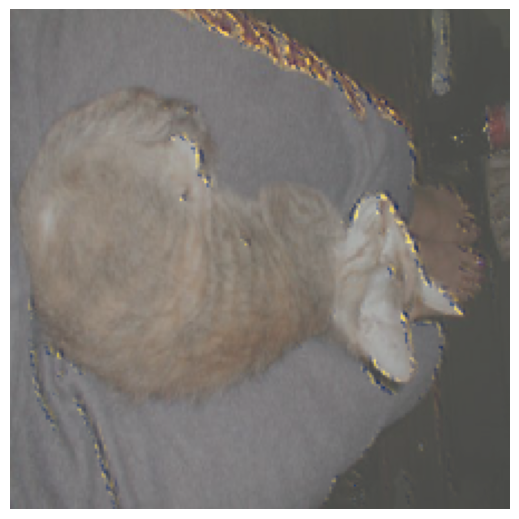

In [19]:
output_layer = -1
batch_size = 16
steps_list = [2, 5, 20, 50, 200]
baseline_value = 0

for steps in steps_list:
    t = time()
    explainer = IntegratedGradients(model,
                                    output_layer=output_layer, batch_size=batch_size,
                                    steps=steps, baseline_value=baseline_value)
    explanation = explainer.explain(x, y)
    print(f"steps: {steps} -> {round(time()-t, 2)}s")

    plot_attributions(explanation, x, img_size=5, cmap='cividis', alpha=0.6)
    plt.show()